In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import csv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd

In [ ]:
import csv
import numpy as np
import cv2

def get_data(filename):
    with open(filename) as training_file:
        csv_reader = csv.reader(training_file, delimiter=',')
        first_line = True
        temp_images = []
        temp_labels = []
        for row in csv_reader:
            if first_line:

                first_line = False
            else:
                temp_labels.append(row[0])
                image_data = row[1:785]
                image_data_as_array = np.array(image_data, dtype='uint8').reshape(28, 28)  # Reshape to 28x28


                img = cv2.resize(image_data_as_array, (75, 75), interpolation=cv2.INTER_LINEAR)


                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                temp_images.append(img)

        images = np.array(temp_images).astype('float')
        labels = np.array(temp_labels).astype('float')
    return images, labels


In [ ]:
train_path = '/content/gdrive/MyDrive/ML_MNIST/sign_mnist_train.csv'
test_path = '/content/gdrive/MyDrive/ML_MNIST/sign_mnist_test.csv'

training_images, training_labels = get_data(train_path)
testing_images, testing_labels = get_data(test_path)

print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 75, 75, 3)
(27455,)
(7172, 75, 75, 3)
(7172,)


In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


validation_datagen = ImageDataGenerator(rescale=1. / 255)


print(training_images.shape)
print(testing_images.shape)


(27455, 75, 75, 3)
(7172, 75, 75, 3)


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import layers, models


pretrained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
pretrained_model.trainable = True


flatten_layer = layers.Flatten()
dropout_layer_1 = layers.Dropout(0.5)
dense_layer_1 = layers.Dense(128, activation='relu')
dropout_layer_2 = layers.Dropout(0.5)
dense_layer_2 = layers.Dense(64, activation='relu')
dropout_layer_3 = layers.Dropout(0.2)
prediction_layer = layers.Dense(26, activation='softmax')

# Constructing the model
model = models.Sequential([
    pretrained_model,
    flatten_layer,
    dropout_layer_1,
    dense_layer_1,
    dropout_layer_2,
    dense_layer_2,
    dropout_layer_3,
    prediction_layer
])


In [ ]:
# Run the CNN model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Hist = model.fit(
        train_datagen.flow(training_images, training_labels, batch_size=128),
        epochs=25,
        validation_data = validation_datagen.flow(testing_images, testing_labels, batch_size=32),
      )

Epoch 1/25
215/215 [==============================] - 106s 373ms/step - loss: 3.2909 - accuracy: 0.0455 - val_loss: 3.2382 - val_accuracy: 0.0639
Epoch 2/25
215/215 [==============================] - 70s 327ms/step - loss: 3.1954 - accuracy: 0.0689 - val_loss: 3.0757 - val_accuracy: 0.1454
Epoch 3/25
215/215 [==============================] - 70s 325ms/step - loss: 2.8795 - accuracy: 0.1676 - val_loss: 2.5719 - val_accuracy: 0.3217
Epoch 4/25
215/215 [==============================] - 70s 325ms/step - loss: 2.3105 - accuracy: 0.3202 - val_loss: 1.8048 - val_accuracy: 0.4392
Epoch 5/25
215/215 [==============================] - 70s 326ms/step - loss: 1.5681 - accuracy: 0.5160 - val_loss: 0.8586 - val_accuracy: 0.7469
Epoch 6/25
215/215 [==============================] - 70s 326ms/step - loss: 0.9401 - accuracy: 0.7101 - val_loss: 0.2901 - val_accuracy: 0.9214
Epoch 7/25
215/215 [==============================] - 70s 327ms/step - loss: 0.5516 - accuracy: 0.8414 - val_loss: 0.1173 - val_a

In [ ]:
model.save("/content/gdrive/MyDrive/ML_MNIST/MNIST_classifier_transfer_Inception.h5")

import pickle
with open('/content/gdrive/MyDrive/ML_MNIST/MNIST_classifier_transfer_Inception.pkl', 'wb') as file:
    pickle.dump(Hist.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


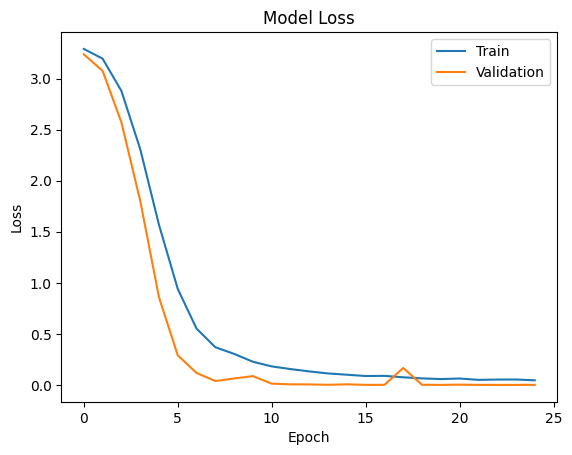

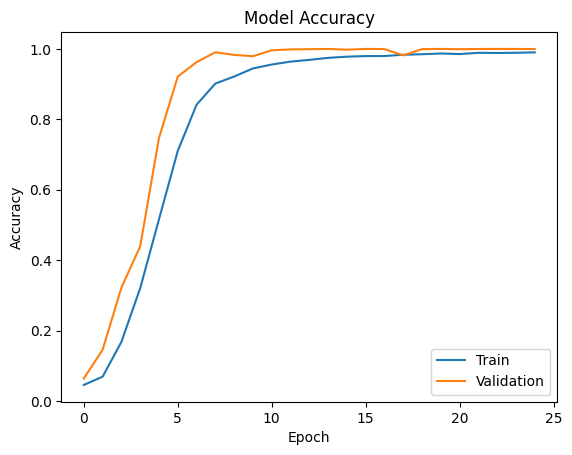

In [ ]:
import matplotlib.pyplot as plt
import pickle


with open('/content/gdrive/MyDrive/ML_MNIST/MNIST_classifier_transfer_Inception.pkl', 'rb') as file:
    history = pickle.load(file)

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


108/108 [==============================] - 10s 13ms/step


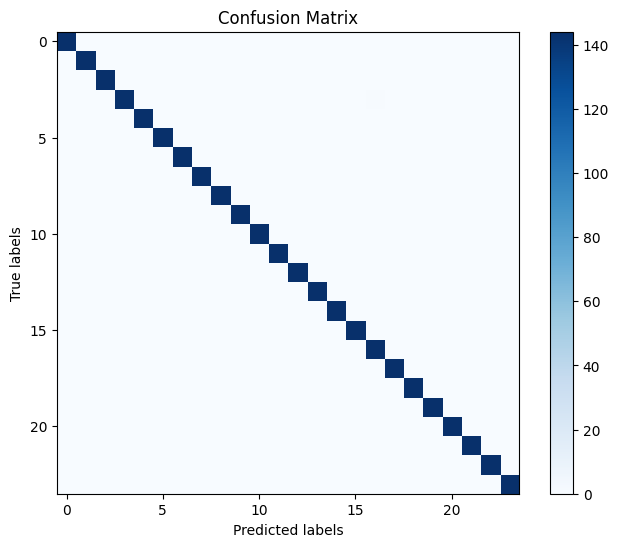

Overall Precision: 0.9997
Overall Recall: 0.9997
Overall F1-score: 0.9997


In [ ]:
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np


model = load_model('/content/gdrive/MyDrive/ML_MNIST/MNIST_classifier_transfer_Inception.h5')



testing_images = testing_images / 255.0  # Normalization


unique_classes, counts = np.unique(testing_labels, return_counts=True)


min_samples = np.min(counts)


undersample = RandomUnderSampler(sampling_strategy={cls: min_samples for cls in unique_classes})
testing_images_reshaped = testing_images.reshape(len(testing_images), -1)
testing_images_resampled, testing_labels_resampled = undersample.fit_resample(testing_images_reshaped, testing_labels)
testing_images_resampled = testing_images_resampled.reshape(-1, 75, 75, 3)

testing_images_resampled, testing_labels_resampled = shuffle(testing_images_resampled, testing_labels_resampled)


predicted_labels = model.predict(testing_images_resampled)
predicted_classes = np.argmax(predicted_labels, axis=1)

conf_matrix = confusion_matrix(testing_labels_resampled, predicted_classes)


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

precision = precision_score(testing_labels_resampled, predicted_classes, average='weighted')
recall = recall_score(testing_labels_resampled, predicted_classes, average='weighted')
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Overall Precision: {precision:.4f}')
print(f'Overall Recall: {recall:.4f}')
print(f'Overall F1-score: {f1:.4f}')


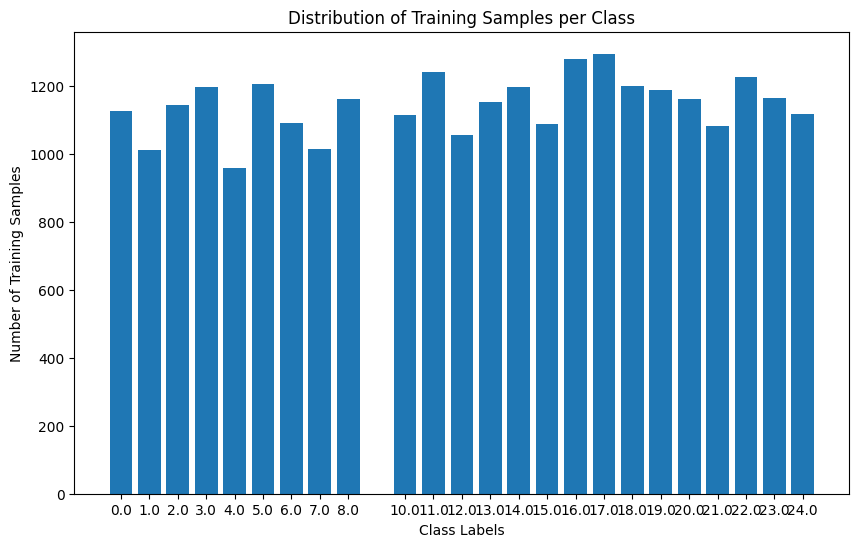

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



unique_labels, counts = np.unique(training_labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, tick_label=unique_labels)
plt.xlabel('Class Labels')
plt.ylabel('Number of Training Samples')
plt.title('Distribution of Training Samples per Class')
plt.show()
